## Generate Context tiles

This notebook shows how to generate context tiles for products like GFW and GFW Climate, via example:

### GFW Climate Biomass 

[GFW climate](http://climate.globalforestwatch.org/map/3/-28.56/79.56/ALL/dark/biomass_loss?begin=2001-11-10&end=2015-01-01&threshold=30) shows Carbon emissions from biomass loss (t CO2/ha).

![](./pics/gfw_biomass.png)

These data enable the user to select a tree cover canopy threshold of interest, and show biomass loss over time, enabling the user to select the time range of interest. 

The data come from webmap tiles.

For example, an old versions of these data produced by Google in 2014 are hosted at:

http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-{threshold}-{z}{/x}{/y}.png

These tiles are decoded by clientside javascript code [here](https://github.com/Vizzuality/gfw-climate/blob/develop/app/assets/javascripts/map/views/layers/BiomassLossLayer.js), and converted into a visulization of biomass loss.

If we zoom into some disctinct areas and examine the contents of the tile we will be able to understand more how these data are put together, and how to replicate them.

We will look at two informative areas, one in Jamaica, which shows 3 clear patches of carbon loss imposed over a small iland area, easy to identify:

<img src="./pics/Jamaica.png" width="600" height="600" />

And another which shows the data cutoff and a distinct error in the previously processed data over the Floridian peninsula:

<img src="./pics/florida.png" width="600" height="600" />


## Set Bucket read permissions to public

To do this you need to add `allUsers` as a new user type to a bucket, with permission to view all files.

![](./pics/perm1.png)


At which point you should see the ACL permission set as follows:

<img src="./pics/perm2.png" width="600" height="600" />


## Set CSRF permissions on buckets

Load Google cloud storage console, and boot the terminal. Then set the CSRF properties for all sites.

```
echo '[{"origin": ["*"],"responseHeader": ["Content-Type"],"method": ["GET", "HEAD"],"maxAgeSeconds": 3600}]' > cors-config.json

gsutil cors set cors-config.json gs://gfw-climate-tiles

```

![](./pics/crs_perm.png)

In [1]:
import requests
import math
import maya
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import os
import ee
import json
import folium
ee.Initialize()
%matplotlib inline

### Examine tiles of data

Before beginning, it is useful to examine tiles of data from the old datasets (and compare to newly created tests as needed in dev).

In [2]:
# functions for Testing/previewing tiles

def deg2num(lat_deg, lon_deg, zoom):
    """Based on a zoom and lat long, find tile numbers.
        Used as a helper to identify which tiles I want to test read.
    """
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)


def get_url_at_loc(image, z, lat, lon, viz_params=None):
    """Create a target url for tiles for an image at a given tile location.
    e.g.
    im = ee.Image("LE7_TOA_1YEAR/" + year).select("B3","B2","B1")
    viz = {'opacity': 1, 'gain':3.5, 'bias':4, 'gamma':1.5}
    url = tile_url(image=im),viz_params=viz)
    """
    if viz_params:
        try:
            d = image.getMapId(viz_params)
        except:
            print('Unable to apply styles to tiles.')
            d = image.getMapId() 
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    
    xtile, ytile = deg2num(lat, lon, z)
    print(xtile, ytile, z)
    location_string = f'/{z}/{xtile}/{ytile}?token='
    
    url = (base_url + '/map/' + d['mapid'] + location_string  + d['token'])
    print(url)
    return url


def show_test_tiles(image_or_url, lat=None, lon=None, z=None):
    """Shows an examination of a set of tiles for a given lat lon z location.
    """
    if isinstance(image_or_url, str):
        im_arrays = misc.imread(requests.get(image_or_url, stream=True).raw, mode='RGBA')
    else:
        assert lat != None,'enter lat if calling tile from ee.Image() type'
        assert lon != None,'enter lon if calling tile from ee.Image() type'
        assert z != None,'enter z if calling tile from ee.Image() type'
        im_arrays = misc.imread(requests.get(get_url_at_loc(image_or_url,z, lat, lon),
                                         stream=True).raw, mode='RGBA')
    for n, band in enumerate(["R","G","B","A"]):
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        f.set_size_inches(10,5)
        ax1.set_title(f"BAND {n}  {band}: max={im_arrays[:,:,n].max()} min={im_arrays[:,:,n].min()}")
        ax1.imshow(im_arrays[:,:,n], cmap='Oranges')
        ax2.set_title(f'Hist of {n} band contents:')
        ax2.hist(im_arrays[:,:,3].flatten(), bins=25, normed=True)
        ax2.set_yscale('log', nonposy='clip')
        plt.show()
    return

In [ ]:
print('Jamaica', deg2num(17.73, -77.18, 9)) # position of Jamaica 
print('N. Florida anomaly',deg2num(30.12, -83.25, 7)) # position north of Florida anomaly
print('North Florida',deg2num(29.05, -82.67, 12)) # north florida

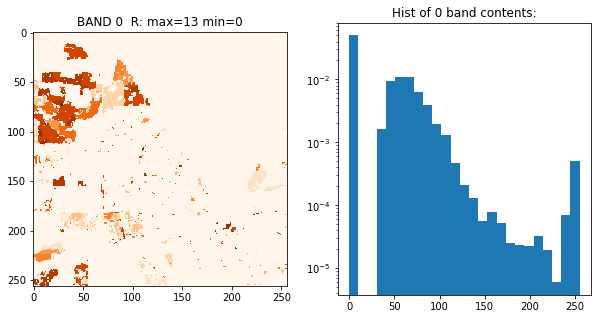

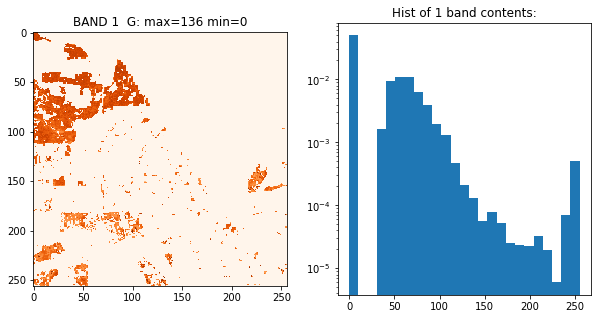

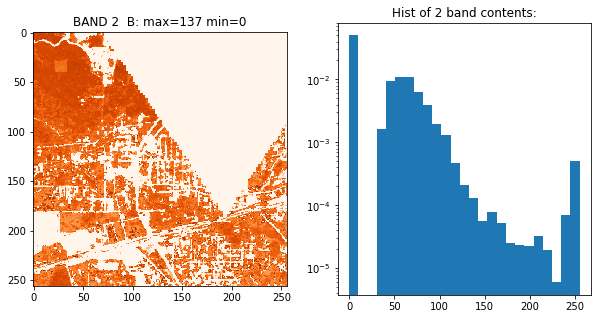

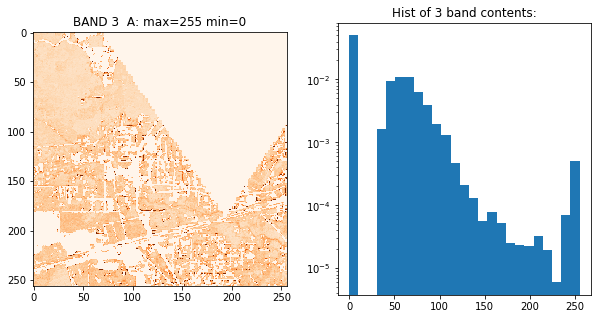

In [3]:
# OLD DATA
#tile_url = 'http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-30-9/146/230.png'
#tile_url = 'http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-30-7/34/52.png'
tile_url = 'http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-30-12/1107/1702.png'

# Simple tests
#tile_url = "https://storage.googleapis.com/gfw_clim/bentest/4/14/8.png"
#tile_url = "https://storage.googleapis.com/gfw-climate-tiles/biomassloss/v2.0/tc10/7/34/52.png"

#tile_url = "https://earthengine.googleapis.com/map/996a1c3df722dea6b98207de3c59c474/12/1107/1702?token=f336a7dac78717aaf4010ae26a547e98"
#tile_url = "https://storage.googleapis.com/gfw-climate-tiles/biomassloss/v2.0/tc10/7/100/61.png"


#show_test_tiles(final_image, lat=17.73, lon=-77.18, z=7) # Jamacia

#show_test_tiles(final_image, lat=30.12, lon=-83.25, z=9) # Florida anomaly

show_test_tiles(tile_url)

## Problem

Looks like it is not possible to send masked data into the ee.image.rgb() argument, as it broadcasts any mask across all three bands.
I will need to unmask the data before creating the RGB image.

* Red channel (band 0): encodes integer year - 2000 (i.e. years since 2000) of tree cover loss for trees >= a specified canopy threshold. With 0 values indicating points where no loss occured.

* Green channel (band 1): Biomass masked by year (and also uncertainty to constrain to tropics), scaled with unitScale(0, 450) and converted to 255

* Blue channel (band 2): Biomass (t/ha) scaled with unitScale(0, 450) and converted to 255. This should be unpacked on the front-end using ((value/917)*255)

* Alpha Channel (band 3): Uncertainty (t/ha) scaled to 255 using the formulae from the E.E. dataset 'users/davethau/whrc_carbon_test/uncertainty' with clamp(0,100) scaled to 255.


Note, in relation to the front-end code, the alpha channel of the decoded png data is not being used. I.e. the alpha channel of the above dataset is not currently being used by the front-end for anything.

Note: By checking the Florida anomaly its possible to verify that everwhere has been masked by the uncertainty data.

### To recreate the dataset

Using updated WHRC biomass data and updated Hansen tree cover data, we now need to re-create the Tau dataset.

1. First, we need to recreate the dataset images in the four bands.
2. Then we need to set the resolution of the layers, iterating through z-levels, downscaling with MODE
3. At each tree-cover threshold and z-level we need to write out the datasets as a tiles.

### Testing

The first stage will be visually testing these data as I create them using Folium:

In [ ]:
# def get_tile_url(image, viz_params=None):
#     """Create a target url for tiles for an image.
#     e.g.
#     im = ee.Image("LE7_TOA_1YEAR/" + year).select("B3","B2","B1")
#     viz = {'opacity': 1, 'gain':3.5, 'bias':4, 'gamma':1.5}
#     url = tile_url(image=im),viz_params=viz)
#     """
#     if viz_params:
#         try:
#             d = image.getMapId(viz_params)
#         except:
#             print('Unable to apply styles to tiles.')
#             d = image.getMapId() 
#     else:
#         d = image.getMapId()
#     base_url = 'https://earthengine.googleapis.com'
#     url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
#     return url

In [ ]:
# # Biomass uncertainty data (which also serves as a PanTropical mask)
# uncertainty = ee.Image('users/davethau/whrc_carbon_test/uncertainty')

# def get_biomass(uncertainty=uncertainty):
#     """ Create Woods Hole RC Biomass data image, scaled by x/917 * 255
#         and converted to byte type.
#     """
#     neotropic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Neotropic')
#     africa = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Africa')
#     australia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Australia')
#     tropasia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Tropical_Asia')
#     palearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Palearctic')
#     nearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Nearctic')
#     # Combine the individual areas into a single collection
#     ic = ee.ImageCollection([africa,australia, nearctic,
#                                  neotropic, palearctic, tropasia])
#     im = ic.max() # Now we have single image, but with discontinuties
#     hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')
#     datamask = hansenImage.select('datamask')
#     mask = datamask.eq(1)
#     land = mask # Make a land image out of the mask
#     landmask = im.mask(land) # Mask land with itself to mask all the zeros (non-land)
#     # make another collection from the landmask and the full coverage image
#     ic_with_mask = ee.ImageCollection([landmask, im])
#     # Finally convert that into a fully contingous image, with 0s where no data over land
#     # and mask those data by uncertainty (as the original data were).
#     biomass = ic_with_mask.max()
#     biomass = biomass.mask(uncertainty).divide(917).multiply(255).byte()
#     return biomass


# def get_loss_year(threshold, uncertainty=uncertainty):
#     """lossyear = get_loss_year(30) # get loss by year for canopy threshold of >30%
#     This function expects that the uncertainty image has already been added to the namespace.
#     """
#     treeThresh = 30         # <--- Tree Thresholding set here (make this a function call in the future)
#     raw_hansen = ee.Image("UMD/hansen/global_forest_change_2016_v1_4") # Up-to-date Hansen data
#     tree_threshold_mask = raw_hansen.select('treecover2000').gte(threshold) 
#     lossyear_for_threshold = raw_hansen.select('lossyear').mask(tree_threshold_mask)
#     loss_by_year = lossyear_for_threshold.mask(lossyear_for_threshold).mask(uncertainty)
#     loss_by_year = loss_by_year.mask(loss_by_year)    
#     return loss_by_year

In [ ]:
# biomass = get_biomass()
# loss_by_year = get_loss_year(30)

In [ ]:
# geom = ee.Feature(ee.Geometry.Polygon(
#         [[[-122.6953125, 31.95216223802497],
#           [-71.015625, 30.44867367928756],
#           [-52.734375, 14.944784875088372],
#           [-39.375, 4.214943141390651],
#           [-15.8203125, 3.5134210456400448],
#           [-30.5859375, 16.299051014581828],
#           [-25.3125, 26.431228064506442],
#           [-15.1171875, 34.30714385628804],
#           [36.5625, 32.84267363195431],
#           [54.4921875, 20.3034175184893],
#           [67.8515625, 33.72433966174761],
#           [127.265625, 30.44867367928756],
#           [136.0546875, 28.304380682962783],
#           [125.5078125, 19.973348786110602],
#           [131.484375, 11.867350911459306],
#           [142.3828125, 11.178401873711785],
#           [140.9765625, 7.013667927566642],
#           [175.78125, -11.5230875068685],
#           [169.1015625, -18.979025953255267],
#           [136.40625, -12.897489183755892],
#           [107.578125, -11.867350911459296],
#           [90.3515625, 0.3515602939922709],
#           [78.3984375, 1.054627942275887],
#           [73.828125, -4.915832801313165],
#           [60.46875, 4.565473550710278],
#           [49.5703125, -1.4061088354351594],
#           [55.546875, -15.284185114076422],
#           [50.9765625, -28.92163128242129],
#           [39.0234375, -28.613459424004418],
#           [34.1015625, -33.13755119234614],
#           [11.25, -33.13755119234614],
#           [5.9765625, -18.979025953255267],
#           [6.328125, -7.01366792756663],
#           [-5.625, -1.7575368113083125],
#           [-30.234375, -3.5134210456400323],
#           [-36.2109375, -21.94304553343817],
#           [-45.3515625, -32.842673631954305],
#           [-74.53125, -33.13755119234614],
#           [-86.8359375, -6.315298538330034],
#           [-97.03125, -5.615985819155327]]]))

In [ ]:
# def get_tile_url(image, viz_params=None):
#     """Create a target url for tiles for an image.
#     e.g.
#     im = ee.Image("LE7_TOA_1YEAR/" + year).select("B3","B2","B1")
#     viz = {'opacity': 1, 'gain':3.5, 'bias':4, 'gamma':1.5}
#     url = tile_url(image=im),viz_params=viz)
#     """
#     if viz_params:
#         try:
#             d = image.getMapId(viz_params)
#         except:
#             print('Unable to apply styles to tiles.')
#             d = image.getMapId() 
#     else:
#         d = image.getMapId()
#     base_url = 'https://earthengine.googleapis.com'
#     url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
#     return url

# # Declare some visulisation styles

# pinkViz = {'min': 0, 'max': 16, 'palette': 'FDC1E3, D581B1, BD257C',}

# whrcPALETTE = "75322B,84512A,8E6232,da8c19,ef9e0b,ffc011,ffdb2d,\
#           ffe215,f9eb46,d5e400,c9d800,becc00,b4c200,B7B95B,B2B659,AFB457,ABB156,\
#           A6AE53,A3AB52,A1AA51,9FA950,9EA850,9CA74F,9BA64E,9AA54E,99A44D,95A24C,\
#           92A04A,909E49,8C9C48,8B9A47,869745,859745,839544,839543,819443,7E9241,\
#           7A8F40,778D3E,758C3E,758B3D,728A3C,71893C,70883B,6F873B,6D863A,6A8438,\
#           678237,648036,627E37,607D34,5E7B33,5A7831,577630,53742E,50722D,4F712C,\
#           4E702C,4C6F2B,4A6D2A,496D29,486C29,486C29,476B29,466A28,426827,3E6525,\
#           3B6323,3A6223,396222,386122,355F21,345E22,315C1F,305B1E,2C591D,2B581C,\
#           28561B,27551A,255419,245319,235218,225218,225118,215118,205017,1F4F17,\
#           1C4E16,1B4D15,1A4C15,194C14,184A14,164913,154812,124711,114610,114610,\
#           114610,114610"
          
# whrcViz = {"max":255,"min":0, 'palette': whrcPALETTE}

# greenViz = {'palette':'ffffff, 009933, 336600, 233f00'}

# polygonViz = {'opacity': 0.3, 'color': 'a97ad6'}

In [ ]:
#final_image.getInfo()

In [ ]:
# Select which tileset you want to preview (folium can only show one at a time currently)

#ee_tiles = get_tile_url(get_biomass(uncertainty), whrcPALETTE)
#ee_tiles = get_tile_url(loss_by_year, pinkViz)
#ee_tiles = get_tile_url(biomass.mask(loss_by_year), whrcViz)
#ee_tiles = get_tile_url(tree_threshold_mask, greenViz)
#ee_tiles = get_tile_url(ee.Feature(geom), polygonViz)
# ee_tiles = get_tile_url(final_image)

# map = folium.Map(location=[-2.53, -46.54], zoom_start=7, tiles='Mapbox Bright' )
# map.add_tile_layer(tiles=ee_tiles, max_zoom=14, min_zoom=0, attr='Earth Engine tiles')

In [ ]:
# map

# Output
## Script the generation of downscaled tiles

Now that we have the three datasets we need loaded, masked and subset required to generate the tiled data, we now need to rigidly set the downsampling method, so as to ensure that the data have the correct apperance at each z-level. We cannot use the default pyramiding scheme. Instead, we will need to iterate over the z-levels, and at each step reduce (using mode) and reproject the data to a new fixed pixel size. We then export the data for that z-level only within the `geom` polygon .

An example of this methodology in action can be seen [here](https://github.com/wri/hansen_ee_processing/blob/master/python/hansen_tiles.py).

Metadta of z-relation to pixel size at equator described [here](https://developers.google.com/earth-engine/exporting).

Note, to write publicly viewable tiles to a bucket you need to ignore the flag writePublicTiles and instead insure that the bucket target is set to public: [see instructions here](https://cloud.google.com/storage/docs/access-control/making-data-public).

In [ ]:
# import os
# import ee
# ee.Initialize()

In [ ]:
# def get_uncertainty():
#     uncertainty = ee.Image('users/davethau/whrc_carbon_test/uncertainty').clamp(0, 100).multiply(2.55)
#     return uncertainty


# def get_biomass(uncertainty):
#     """ Create Woods Hole RC Biomass data image, scaled by x/917 * 255
#         and converted to byte type.
#     """
#     neotropic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Neotropic')
#     africa = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Africa')
#     australia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Australia')
#     tropasia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Tropical_Asia')
#     palearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Palearctic')
#     nearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Nearctic')
#     # Combine the individual areas into a single collection
#     ic = ee.ImageCollection([africa,australia, nearctic,
#                                  neotropic, palearctic, tropasia])
#     im = ic.max() # Now we have single image, but with discontinuties
#     hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')
#     datamask = hansenImage.select('datamask')
#     mask = datamask.eq(1)
#     land = mask # Make a land image out of the mask
#     landmask = im.mask(land) # Mask land with itself to mask all the zeros (non-land)
#     # make another collection from the landmask and the full coverage image
#     ic_with_mask = ee.ImageCollection([landmask, im])
#     # Finally convert that into a fully contingous image, with 0s where no data over land
#     # and mask those data by uncertainty (as the original data were).
#     biomass = ic_with_mask.max()
#     biomass = biomass.mask(uncertainty).divide(917).multiply(255).byte()
#     return biomass


# def get_loss_year(threshold, uncertainty):
#     """lossyear = get_loss_year(30) # get loss by year for canopy threshold of >30%
#     This function expects that the uncertainty image has already been added to the namespace.
#     """
#     raw_hansen = ee.Image("UMD/hansen/global_forest_change_2016_v1_4") # Up-to-date Hansen data
#     tree_threshold_mask = raw_hansen.select('treecover2000').gte(threshold) 
#     lossyear_for_threshold = raw_hansen.select('lossyear').mask(tree_threshold_mask)
#     loss_by_year = lossyear_for_threshold.mask(lossyear_for_threshold).mask(uncertainty)
#     loss_by_year = loss_by_year.mask(loss_by_year)    
#     return loss_by_year

In [ ]:
# def downscale(img_at_z_plus_1, z, z_max=12, max_pixs=65535):
#     if z == z_max:
#         return img_at_z_plus_1
#     else:
#         return img_at_z_plus_1.reproject(
#                     scale=z_to_m[z+1],
#                     crs="EPSG:4326"
#                 ).reduceResolution(
#                     reducer=ee.Reducer.mode(),
#                     maxPixels=max_pixs,
#                     bestEffort=True,
#                 ).reproject(
#                         scale=z_to_m[z],
#                         crs="EPSG:4326"
#                 )




In [ ]:
# scale=27.829872698318393
# #max_pixs=65500 
# full_intensity=255
# thresholds=[10, 15, 20, 25, 30, 50, 75]

# # dictionary of z to meteres
# z_to_m = {0: 156000,
#           1: 78000,
#           2: 39000,
#           3: 20000,
#           4: 10000,
#           5: 4900,
#           6: 2400,
#           7: 1200,
#           8: 611,
#           9: 305,
#           10: 152,
#           11: 76,
#           12: 38}

### Replicate the 'Inside loop' functionality

Brookie used a method of downsampling wherein the image was mutating through the loop. However at z 7 we need to create an intermediate asset. That asset will then be used to continue the loop.

Check if this affects the result: `.mask(treeMask.multiply(scaledUncertainty).unitScale(0,100))`

In [ ]:
# generate_tiles = False
# geom = get_geom()
# for threshold in thresholds:
#     # At the start of each threshold category, get the data and mask by threshold, loss and uncertainty
#     uncertainty = get_uncertainty()
#     band1 = get_loss_year(threshold, uncertainty=uncertainty) # loss yr masked by uncertainty and TC threshold
#     biomass = get_biomass(uncertainty=uncertainty)  # Biomass masked by uncertainty
#     #band2 = tmp_band3.mask(band1) # Biomass masked by loss-yr, TC threshold and uncertainty (shallow copy of tmp_band3)
#     #band3 = get_biomass(uncertainty=band4) # Biomass masked by uncertainty
#     # For each z-level starting from 12 ending at 3
#     for z in range(12, 11, -1):
#         print(f'processing z{z}: {z_to_m[z]:,g}m' )
#         # Downscale the bands according to the z level
#         band1 = downscale(band1, z)
#         biomass = downscale(biomass, z)
#         #band3 = downscale(band3, z)
#         uncertainty = downscale(uncertainty, z)
#         # Add the bands to a single image
#         #final_image = band1.addBands(band2).addBands(
#         #    band3).rename('year', 'total_biomass_loss', 'density')

#         final_image = band1.unmask().addBands(
#             biomass.mask(band1).unmask()).addBands(
#             biomass.unmask()).rename('year','total_biomass_loss','density')
        
#         # write to tiles specifically for the threshold and z-level of the current loop
#         if z == 6 and generate_tiles:
#             print(f'Writing z{z}')
#             export_tiles(image=final_image, z=z, v=2.0, threshold=threshold,
#                          geom=geom, bucket='gfw-climate-tiles', verbose=True)
            
#         if z == 3:
#             # Brookie usually saves an asset at zoom level 7, from which to generate
#             # 6,5,4,3,2
#             export_asset(image=final_image, z=z, scale=z_to_m[z], threshold=threshold, geom=geom,
#                  maxpix=500000000, verbose=True)
#     break
#     print('shouldnt see this - we only want to do one threshold to begin with')

### Outside loop

Load the intermediate asset and resume the processing. Note, after this is functional, I can combine these back into one code block. 


In [ ]:
# for threshold in thresholds:
#     # At the start of each threshold category, get the data and mask by threshold, loss and uncertainty
#     # READ FROM THE INTERMEDIATE ASSET
# #     band4 = get_uncertainty()
# #     band1 = get_loss_year(threshold, uncertainty=band4) # loss yr masked by uncertainty and TC threshold
# #     band3 = get_biomass(uncertainty=band4)  # Biomass masked by uncertainty
# #     band2 = band3.mask(band1) # Biomass masked by loss-yr, TC threshold and uncertainty
#     # For each z-level starting from 6 ending at 3
#     for z in range(6, 2, -1):
#         print(f'processing z{z}: {z_to_m[z]:,g}m' )
#         # Downscale the bands according to the z level
#         band1 = downscale(band1, z)
#         band2 = downscale(band2, z)
#         band3 = downscale(band3, z)
#         band4 = downscale(band4, z)
#         # Add the bands to a single image
#         final_image = band1.addBands(band2).addBands(
#             band3).rename('year', 'total_biomass_loss', 'density')
#         # write to tiles specifically for the threshold and z-level of the current loop
#         if z < 7:
#             print(f'Writing z{z}')
#             export_tiles(image=final_image, z=z, v=2.0, threshold=threshold,
#                          geom=geom, bucket='gfw-climate-tiles', verbose=True)

#     break
#     print('shouldnt see this - we only want to do one threshold to begin with')

# Output

## Version 2

In the second version I need to be much more careful about how masking is handled:


* get tree cover and turn into threshold mask
* get uncertainty mask
* get yearloss
* get biomass
* mask bands and then unmask - confirm that this has set former mask value to 0
* combine bands into a single RGB image

* enter loop
* downscale
* output tiles at each z level until z7, subet by geometry object
* at z 7 write out an intermediate asset

* start the loop again using the intermediate asset as a source file 

In [4]:
import os
import ee
ee.Initialize()

In [5]:
def get_loss_yr():
    """
        Returns an unmasked loss year image from Hansen data
    """
    raw_hansen = ee.Image("UMD/hansen/global_forest_change_2016_v1_4") # Up-to-date Hansen data
    lossyear = raw_hansen.select('lossyear')
    return lossyear

def get_uncertainty():
    """
        Return the uncertainty data
    """
    uncertainty = ee.Image('users/davethau/whrc_carbon_test/uncertainty').clamp(0, 100).multiply(2.55)
    return uncertainty


def get_biomass():
    """
        Create Woods Hole RC Biomass data image, scaled by x/917 * 255
        and converted to byte type ready to export as data in an RGB image
    """
    neotropic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Neotropic')
    africa = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Africa')
    australia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Australia')
    tropasia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Tropical_Asia')
    palearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Palearctic')
    nearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Nearctic')
    # Combine the individual areas into a single collection
    ic = ee.ImageCollection([africa, australia, nearctic,
                                 neotropic, palearctic, tropasia])
    im = ic.max() # Now we have single image, but with discontinuties
    hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')
    datamask = hansenImage.select('datamask')
    mask = datamask.eq(1)
    land = mask # Make a land image out of the mask
    landmask = im.mask(land) # Mask land with itself to mask all the zeros (non-land)
    # make another collection from the landmask and the full coverage image
    ic_with_mask = ee.ImageCollection([landmask, im])
    # Finally convert that into a fully contingous image, with 0s where no data over land
    # and mask those data by uncertainty (as the original data were).
    biomass = ic_with_mask.max().unmask()
    biomass = biomass.divide(917).multiply(255).byte()
    return biomass


def get_treemask(threshold):
    """
        Get a mask for a given tree cover threshold
    """
    raw_hansen = ee.Image("UMD/hansen/global_forest_change_2016_v1_4")
    tree_threshold_mask = raw_hansen.select('treecover2000').gte(threshold) 
    return tree_threshold_mask



def get_geom():
    return ee.Geometry.Polygon(
            [[[-122.6953125, 31.95216223802497],
              [-71.015625, 30.44867367928756],
              [-52.734375, 14.944784875088372],
              [-39.375, 4.214943141390651],
              [-15.8203125, 3.5134210456400448],
              [-30.5859375, 16.299051014581828],
              [-25.3125, 26.431228064506442],
              [-15.1171875, 34.30714385628804],
              [36.5625, 32.84267363195431],
              [54.4921875, 20.3034175184893],
              [67.8515625, 33.72433966174761],
              [127.265625, 30.44867367928756],
              [136.0546875, 28.304380682962783],
              [125.5078125, 19.973348786110602],
              [131.484375, 11.867350911459306],
              [142.3828125, 11.178401873711785],
              [140.9765625, 7.013667927566642],
              [175.78125, -11.5230875068685],
              [169.1015625, -18.979025953255267],
              [136.40625, -12.897489183755892],
              [107.578125, -11.867350911459296],
              [90.3515625, 0.3515602939922709],
              [78.3984375, 1.054627942275887],
              [73.828125, -4.915832801313165],
              [60.46875, 4.565473550710278],
              [49.5703125, -1.4061088354351594],
              [55.546875, -15.284185114076422],
              [50.9765625, -28.92163128242129],
              [39.0234375, -28.613459424004418],
              [34.1015625, -33.13755119234614],
              [11.25, -33.13755119234614],
              [5.9765625, -18.979025953255267],
              [6.328125, -7.01366792756663],
              [-5.625, -1.7575368113083125],
              [-30.234375, -3.5134210456400323],
              [-36.2109375, -21.94304553343817],
              [-45.3515625, -32.842673631954305],
              [-74.53125, -33.13755119234614],
              [-86.8359375, -6.315298538330034],
              [-97.03125, -5.615985819155327]]])


def get_write_target(version, threshold):
    """ e.g. get_write_target('gfw-climate-tiles', 2.0, 30)"""
    return 'bl/v{}/tc{}'.format(str(version), str(threshold))


def export_tiles(image, z, v, threshold, geom, bucket, verbose=False):
    """Create tiles for a specified z level.
    z = z-level (integer between 0 and 23)
    v = version number of a dataset (e.g. 1.0)
    threshold = integer tree cover threshold
    geom = ee.geometry object within setting the region from
            within which to generate tiles
    verbose = True to print status
    """
    tiles_path = get_write_target( v, threshold)
    name=tiles_path.replace('/','_')
    if verbose: print('tiles:', z, tiles_path, name)
    task=ee.batch.Export.map.toCloudStorage(
        fileFormat='png',
        image=image,
        description='{}_{}'.format(name, z), 
        bucket=bucket, 
        path='tmp_test'+tiles_path, 
        writePublicTiles=False,  # write to a public bucket and ignore the flag
        maxZoom=z, 
        minZoom=z, 
        region=geom.coordinates().getInfo(), 
        skipEmptyTiles=True
    )
    task.start()
    if verbose: print(task.status())
    return task



def export_asset(image, z, scale, threshold, geom, maxpix=500000000, verbose=False):
    """Exports a temporary asset (typically at z7)
        and usually to the destination users/benlaken/tmp-7-{threshold}
    """
    #name=zlevel_asset_name(v, z, threshold)
    name = 'tmp_name_test'
    if verbose: print('asset:', z, name)
    task=ee.batch.Export.image.toAsset(
        image=image, 
        description='Temporary Asset', 
        assetId='users/benlaken/tmp-{}-{}'.format(z, threshold), 
        scale=scale, 
        crs="EPSG:4326", 
        region=geom.coordinates().getInfo(),
        maxPixels=maxpix
    )
    task.start()
    if verbose: print(task.status())
    return task


def downscale(img_at_z_plus_1, z, z_max=12, max_pixs=65535):
    if z == z_max:
        return img_at_z_plus_1
    else:
        return img_at_z_plus_1.reproject(
                    scale=z_to_m[z+1],
                    crs="EPSG:4326"
                ).reduceResolution(
                    reducer=ee.Reducer.mode(),
                    maxPixels=max_pixs,
                    bestEffort=True,
                ).reproject(
                        scale=z_to_m[z],
                        crs="EPSG:4326"
                )

In [ ]:
# Testing core logic
#ly = get_loss_yr()
#bm = get_biomass()
#u = get_uncertainty()
#treeMask = get_treemask(30)

#final_image = ee.Image.rgb(ly, bm.mask(ly).unmask(), bm).mask(treeMask.multiply(uncertainty).unitScale(0,100))
#show_test_tiles( final_image )

In [ ]:
# ly = get_loss_yr()
# bm = get_biomass()
# u = get_uncertainty()
# treeMask = get_treemask(30)
# final_image = ee.Image.rgb(ly, bm.mask(ly).unmask(), bm).mask(treeMask.multiply(uncertainty).unitScale(0,100))


In [6]:
#scale=27.829872698318393
#max_pixs=65500 
#full_intensity=255

thresholds=[10, 15, 20, 25, 30, 50, 75]

# dictionary of z to meteres
z_to_m = {0: 156000,
          1: 78000,
          2: 39000,
          3: 20000,
          4: 10000,
          5: 4900,
          6: 2400,
          7: 1200,
          8: 611,
          9: 305,
          10: 152,
          11: 76,
          12: 38}

In [8]:
# Outside loop (12 to 7 with export asset to run at 7)

generate_tiles = True
generate_asset = True
geom = get_geom()
for threshold in thresholds:
    # For each threshold, reset the data, and change the tree mask threshold 
    ly = get_loss_yr()
    bm = get_biomass()
    u = get_uncertainty()
    treeMask = get_treemask(threshold)
    for z in range(12, 6, -1):
        print(f"TC threshold >{threshold}% -- z-level={z} -- pixel scale={z_to_m[z]:,g}m")
        ly = downscale(ly.mask(ly), z).unmask()
        bm = downscale(bm.mask(bm), z).unmask()
        u = downscale(u.mask(u), z).unmask()
        treeMask = downscale(treeMask.mask(treeMask), z).unmask()
        final_image = ee.Image.rgb(ly, bm.mask(ly).unmask(), bm).mask(
                        treeMask.multiply(u).unitScale(0,100)).rename('year','total_biomass_loss','density')
        #final_image = downscale(final_image, z)  # mutate the final image with z-levels
        if generate_tiles:
            export_tiles(final_image, z=z, v='2.0', threshold=threshold,
                         geom=geom, bucket='gfw-climate-tiles', verbose=True)
        if generate_asset and z == 7:
            print('Generating Export Asset')
            tmp_output = ly.unmask().addBands(
                             bm.unmask()).addBands(
                             u).addBands(treeMask).rename('year','density','uncertainty','treeMask')
            export_asset(tmp_output, z=z, scale=z_to_m[z],
                         threshold=threshold, geom=geom,
                         maxpix=500000000, verbose=True)
    break

TC threshold >10% -- z-level=12 -- pixel scale=38m
TC threshold >10% -- z-level=11 -- pixel scale=76m
TC threshold >10% -- z-level=10 -- pixel scale=152m
TC threshold >10% -- z-level=9 -- pixel scale=305m
TC threshold >10% -- z-level=8 -- pixel scale=611m
TC threshold >10% -- z-level=7 -- pixel scale=1,200m
tiles: 7 bl/v2.0/tc10 bl_v2.0_tc10
{'id': 'GXJX6T3IMVUUPJJDMMNLR4EV', 'state': 'READY', 'creation_timestamp_ms': 1509120075717, 'update_timestamp_ms': 1509120075717, 'description': 'bl_v2.0_tc10_7', 'task_type': 'EXPORT_TILES'}
Generating Export Asset
asset: 7 tmp_name_test
{'id': 'KXHXXZTCF6NC5QEXY5XJALZ4', 'state': 'READY', 'creation_timestamp_ms': 1509120078710, 'update_timestamp_ms': 1509120078710, 'description': 'Temporary Asset', 'task_type': 'EXPORT_IMAGE'}


In [ ]:
# Inside loop (6 to 3) reading from exported asset
generate_tiles = False
geom = get_geom()
for threshold in thresholds:
    # access the temporary objects at z7 and retrieve the bands (~150mb each asset)
    import_asset = ee.Image(f'users/benlaken/tmp-7-{threshold}') 
    ly = import_asset.select('year')
    bm = import_asset.select('density')
    u = import_asset.select('uncertainty')
    treeMask = import_asset.select('treeMask')
    # Return to looping and writing out z levels for 6 to 3
    for z in range(6, 2, -1):
    print(f"TC threshold >{threshold}% -- z-level={z} -- pixel scale={z_to_m[z]:,g}m")
    ly = downscale(ly.mask(ly), z).unmask()
    bm = downscale(bm.mask(bm), z).unmask()
    u = downscale(u.mask(u), z).unmask()
    treeMask = downscale(treeMask.mask(treeMask), z).unmask()
    final_image = ee.Image.rgb(ly, bm.mask(ly).unmask(), bm).mask(
                    treeMask.multiply(u).unitScale(0,100)).rename('year','total_biomass_loss','density')
    if generate_tiles and z == 7:
        export_tiles(final_image, z=z, v='2.0', threshold=threshold,
                     geom=geom, bucket='gfw-climate-tiles', verbose=True)
    break

In [ ]:
#final_image = ee.Image.rgb(ly, bm.mask(ly).unmask(), bm).mask(
#    treeMask.multiply(u).unitScale(0,100)).rename('year','total_biomass_loss','density')
#final_image = band1.unmask().addBands(
#             biomass.mask(band1).unmask()).addBands(
#             biomass.unmask()).rename('year','total_biomass_loss','density')

### Check the created files

Test to see if the generated tiles are generated and accessible and appear correct. The image objects can be checked, or we can access the tile urls directly.

In [ ]:
import folium

In [ ]:
def get_tile_url(image, viz_params=None):
    """Create a target url for tiles for an image.
    e.g.
    im = ee.Image("LE7_TOA_1YEAR/" + year).select("B3","B2","B1")
    viz = {'opacity': 1, 'gain':3.5, 'bias':4, 'gamma':1.5}
    url = tile_url(image=im),viz_params=viz)
    """
    if viz_params:
        try:
            d = image.getMapId(viz_params)
        except:
            print('Unable to apply styles to tiles.')
            d = image.getMapId() 
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
    return url



# Declare some visulisation styles
pinkViz = {'min': 0, 'max': 16, 'palette': 'FDC1E3, D581B1, BD257C',}

whrcPALETTE = "75322B,84512A,8E6232,da8c19,ef9e0b,ffc011,ffdb2d,\
          ffe215,f9eb46,d5e400,c9d800,becc00,b4c200,B7B95B,B2B659,AFB457,ABB156,\
          A6AE53,A3AB52,A1AA51,9FA950,9EA850,9CA74F,9BA64E,9AA54E,99A44D,95A24C,\
          92A04A,909E49,8C9C48,8B9A47,869745,859745,839544,839543,819443,7E9241,\
          7A8F40,778D3E,758C3E,758B3D,728A3C,71893C,70883B,6F873B,6D863A,6A8438,\
          678237,648036,627E37,607D34,5E7B33,5A7831,577630,53742E,50722D,4F712C,\
          4E702C,4C6F2B,4A6D2A,496D29,486C29,486C29,476B29,466A28,426827,3E6525,\
          3B6323,3A6223,396222,386122,355F21,345E22,315C1F,305B1E,2C591D,2B581C,\
          28561B,27551A,255419,245319,235218,225218,225118,215118,205017,1F4F17,\
          1C4E16,1B4D15,1A4C15,194C14,184A14,164913,154812,124711,114610,114610,\
          114610,114610"
          
whrcViz = {"max":255,"min":0, 'palette': whrcPALETTE}

In [ ]:
our_tiles = "https://storage.googleapis.com/gfw-climate-tiles/tmp_testbl/v2.0/tc10/{z}/{x}/{y}.png"
#old_tiles = "http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-10-{z}/{x}/{y}.png"

In [ ]:
map = folium.Map(location=[30.12, -83.25], zoom_start=7, tiles='Mapbox Bright' )
#map.add_tile_layer(tiles=our_tiles, max_zoom=14, min_zoom=0, attr='Earth Engine tiles')
map.add_tile_layer(tiles=get_tile_url(final_image), max_zoom=14, min_zoom=0, attr='Earth Engine tiles')

In [ ]:
map